In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import clean
import resources

### Cleaning the dataset
* Step 1: Import excel sheets 
* Step 2: Remove redundant col names from Worker df (Shift Start Date, Shift End Date)
* Step 3: Merged Unfufiled and filled dataframes together, labeling "Worker ID" for the unfulfilled shifts as "unfulfilled"
* Step 4: Created a shift length col for Shift df
* Step 5: Added in a Role classification col for both dfs (NP, CC, Scribe)
* Step 6: Imputed missing preferred hours in worker df using: (actual hours worked / 4 weeks)
* Step 7: Return cleaned dfs: Workers, Shifts

*View clean.py for a detailed walkthrough of how the datasets were cleaned*

In [2]:
workers, shifts = clean.clean_shifts()

***

### Issue 1: unfulfilled vs filled shifts
##### Insights
* NPs have the greatest percent of unfulfilled shifts: out of ~3000 hours, 352 were unfulfilled (12%)
* Of all the NP shifts, NP CA saw the most ufufilled hours: out of ~1000 hours, ~200 were unfulfilled (18%)
* Of the NP CA Shifts the majority (52%) of all missed shifts happened to be shifts within the afternoon shifts (12pm - 5pm)

In [3]:
# Creating function to create pivot charts to examine Total unfulfilled, fulfilled, total and percent by role type
def unfulfilled_pivot(shifts,group):
    # Group by
    unfulfilled = shifts[shifts['Worker ID'] == 'unfulfilled'].groupby(group)['Shift Length'].sum()
    fufilled = shifts[shifts['Worker ID'] != 'unfulfilled'].groupby(group)['Shift Length'].sum()

    # Concat two dfs together 
    all_shifts = pd.concat([unfulfilled, fufilled],axis = 1, keys=['Unfulfilled Hours', 'Fulfilled Hours'])
    all_shifts['Unfulfilled Hours'] = all_shifts['Unfulfilled Hours'].fillna(0)

    # Creating total shift hour col
    all_shifts['Total Shift Hours'] = all_shifts['Unfulfilled Hours'] + all_shifts['Fulfilled Hours']

    # Creating percent unfulfilled col
    all_shifts['Percent unfulfilled Hours'] = round(all_shifts['Unfulfilled Hours'] / all_shifts['Total Shift Hours'],3)*100

    all_shifts = all_shifts.reset_index()
    return all_shifts

In [4]:
role_pivot = unfulfilled_pivot(shifts,'Role')
role_pivot

,Role,Unfulfilled Hours,Fulfilled Hours,Total Shift Hours,Percent unfulfilled Hours
0,CC,210,4998,5208,4.0
1,NP,352,2576,2928,12.0
2,Scribe,56,2842,2898,1.9


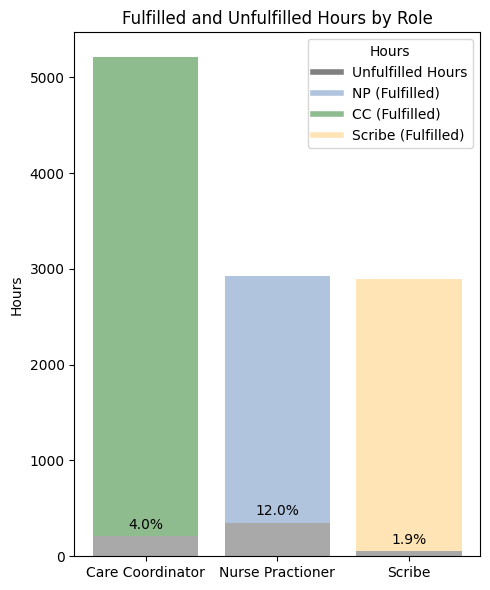

In [5]:
# Define color_map
color_map = resources.color_map

# Filter Dataframe and add color
role_pivot = role_pivot.sort_values(by=['Role','Total Shift Hours'],ascending = [True,False])
role_pivot = role_pivot[role_pivot['Percent unfulfilled Hours'] != 0]
role_pivot['Color_f'] = role_pivot['Role'].map(color_map)
role_pivot['Color_u'] = 'darkgrey'

fulfilled_colors = role_pivot['Color_f'].tolist()
unfulfilled_colors = role_pivot['Color_u'].tolist()

# Create the stacked bar chart manually
fig, ax = plt.subplots(figsize=(5, 6
                                ))

# X positions of each bar
bar_positions = range(len(role_pivot))

# Plot "Unfulfilled Hours" as the base (gray)
ax.bar(
    bar_positions, role_pivot['Unfulfilled Hours'],
    color=unfulfilled_colors, label='Unfulfilled Hours'
)

# Plot "Fulfilled Hours" on top (role-based colors)
ax.bar(
    bar_positions, role_pivot['Fulfilled Hours'],
    bottom= role_pivot['Unfulfilled Hours'],
    color=fulfilled_colors, label='Fulfilled Hours'
)

# Set x-ticks and labels
plt.ylabel('Hours')
plt.xticks(bar_positions, ['Care Coordinator','Nurse Practioner','Scribe'])
plt.title('Fulfilled and Unfulfilled Hours by Role')

# Add percentage labels to the stacked bars
for i, (unf, ful) in enumerate(zip(role_pivot['Unfulfilled Hours'], role_pivot['Fulfilled Hours'])):
    percent_unf = role_pivot['Percent unfulfilled Hours'].iloc[i]
    total_hours = unf + ful
    # Position for unfulfilled percentage label
    ax.text(i, unf + 75, f'{percent_unf:.1f}%', ha='center')

plt.grid(axis='y')
legend_elements = [
    plt.Line2D([0], [0], color='gray', lw=4, label='Unfulfilled Hours'),
    plt.Line2D([0], [0], color='lightsteelblue', lw=4, label='NP (Fulfilled)'),
    plt.Line2D([0], [0], color='darkseagreen', lw=4, label='CC (Fulfilled)'),
    plt.Line2D([0], [0], color='moccasin', lw=4, label='Scribe (Fulfilled)')
]

# Add the custom legends to the plot
ax.legend(handles=legend_elements, title='Hours')
plt.grid(visible=False)
plt.tight_layout()
# plt.savefig('Issue1_chart1.png', dpi=300) 

plt.show()

In [6]:
# Using the function unfulfilled_pivot created above to create a groupby df by positions 
position_pivot = unfulfilled_pivot(shifts,'Positions')
position_pivot

,Positions,Unfulfilled Hours,Fulfilled Hours,Total Shift Hours,Percent unfulfilled Hours
0,NP - RN Team - Tasks,29.0,253,282.0,10.3
1,NP CA,198.0,855,1053.0,18.8
2,NP CA+NY,12.0,16,28.0,42.9
3,NP CA+NY+DC,69.0,912,981.0,7.0
4,NP NY,39.0,424,463.0,8.4
5,NP NY+DC,5.0,105,110.0,4.5
6,Remote CC - Tasks,66.0,1932,1998.0,3.3
7,Remote CC - Chat-Tasks,87.0,1801,1888.0,4.6
8,Remote CC - Urgent Coordination - Tasks,24.0,393,417.0,5.8
9,Remote CC - Zendesk - Tasks,33.0,735,768.0,4.3


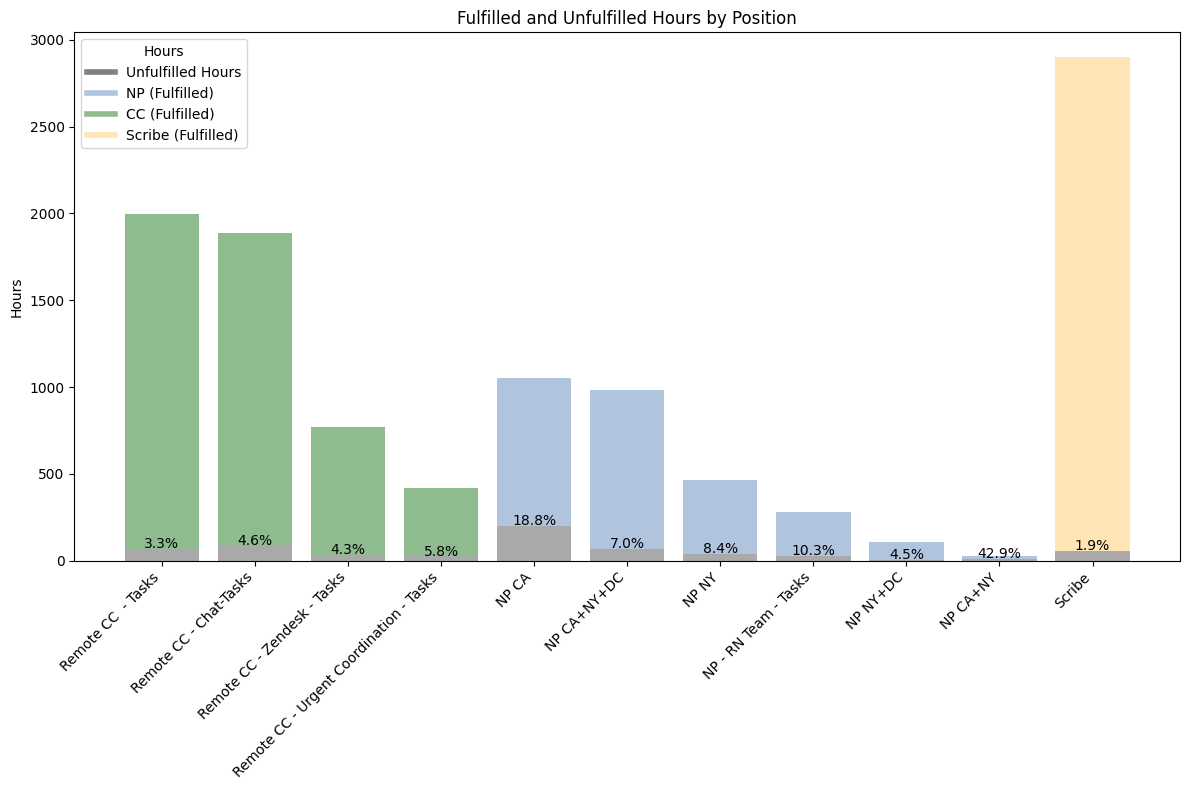

In [7]:
# Filter Dataframe and add color
position_pivot = clean.Role_classification(position_pivot)
position_pivot = position_pivot.sort_values(by=['Role','Total Shift Hours'],ascending = [True,False])
position_pivot = position_pivot[position_pivot['Percent unfulfilled Hours'] != 0]
position_pivot['Color_f'] = position_pivot['Role'].map(color_map)
position_pivot['Color_u'] = 'darkgrey'

fulfilled_colors = position_pivot['Color_f'].tolist()
unfulfilled_colors = position_pivot['Color_u'].tolist()

# Create the stacked bar chart manually
fig, ax = plt.subplots(figsize=(12, 8))

# X positions of each bar
bar_positions = range(len(position_pivot))

# Plot "Unfulfilled Hours" as the base (gray)
ax.bar(
    bar_positions, position_pivot['Unfulfilled Hours'],
    color=unfulfilled_colors, label='Unfulfilled Hours'
)

# Plot "Fulfilled Hours" on top (role-based colors)
ax.bar(
    bar_positions, position_pivot['Fulfilled Hours'],
    bottom=position_pivot['Unfulfilled Hours'],
    color=fulfilled_colors, label='Fulfilled Hours'
)

# Set x-ticks and labels
plt.ylabel('Hours')
plt.xticks(bar_positions, position_pivot['Positions'], rotation=45, ha='right')
plt.title('Fulfilled and Unfulfilled Hours by Position')

# Add percentage labels to the stacked bars
for i, (unf, ful) in enumerate(zip(position_pivot['Unfulfilled Hours'], position_pivot['Fulfilled Hours'])):
    percent_unf = position_pivot['Percent unfulfilled Hours'].iloc[i]
    total_hours = unf + ful
    # Position for unfulfilled percentage label
    ax.text(i, unf + 5, f'{percent_unf:.1f}%', ha='center')

plt.grid(axis='y')
legend_elements = [
    plt.Line2D([0], [0], color='gray', lw=4, label='Unfulfilled Hours'),
    plt.Line2D([0], [0], color='lightsteelblue', lw=4, label='NP (Fulfilled)'),
    plt.Line2D([0], [0], color='darkseagreen', lw=4, label='CC (Fulfilled)'),
    plt.Line2D([0], [0], color='moccasin', lw=4, label='Scribe (Fulfilled)')
]

# Add the custom legends to the plot
ax.legend(handles=legend_elements, title='Hours')
plt.tight_layout()
plt.grid(visible=False)
# plt.savefig('Issue1_chart2.png', dpi=300) 
plt.show()

In [8]:
position_pivot.groupby('Role').sum()

,Positions,Unfulfilled Hours,Fulfilled Hours,Total Shift Hours,Percent unfulfilled Hours,Color_f,Color_u
Role,,,,,,,
CC,Remote CC - TasksRemote CC - Chat-TasksRemote...,210.0,4861,5071.0,18.0,darkseagreendarkseagreendarkseagreendarkseagreen,darkgreydarkgreydarkgreydarkgrey
NP,NP CANP CA+NY+DCNP NYNP - RN Team - TasksNP NY...,352.0,2565,2917.0,91.9,lightsteelbluelightsteelbluelightsteelblueligh...,darkgreydarkgreydarkgreydarkgreydarkgreydarkgrey
Scribe,Scribe,56.0,2842,2898.0,1.9,moccasin,darkgrey


In [9]:
# Importing Positional_Pivot from clean.py to analyze unfulfilled shifts for NP CA by hour and time of day
hour, day  = clean.Positional_Pivot(shifts, 'NP CA')

c:\Users\A654219\Documents\Forward Jam\Staffing\clean.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = pivot_df.groupby('Shift Category').sum()


In [10]:
day

,Unfulfilled,Fulfilled
Shift Category,,
Morning,40.0,245.0
Afternoon,119.0,274.0
Evening,39.0,213.0
Night,0.0,123.0


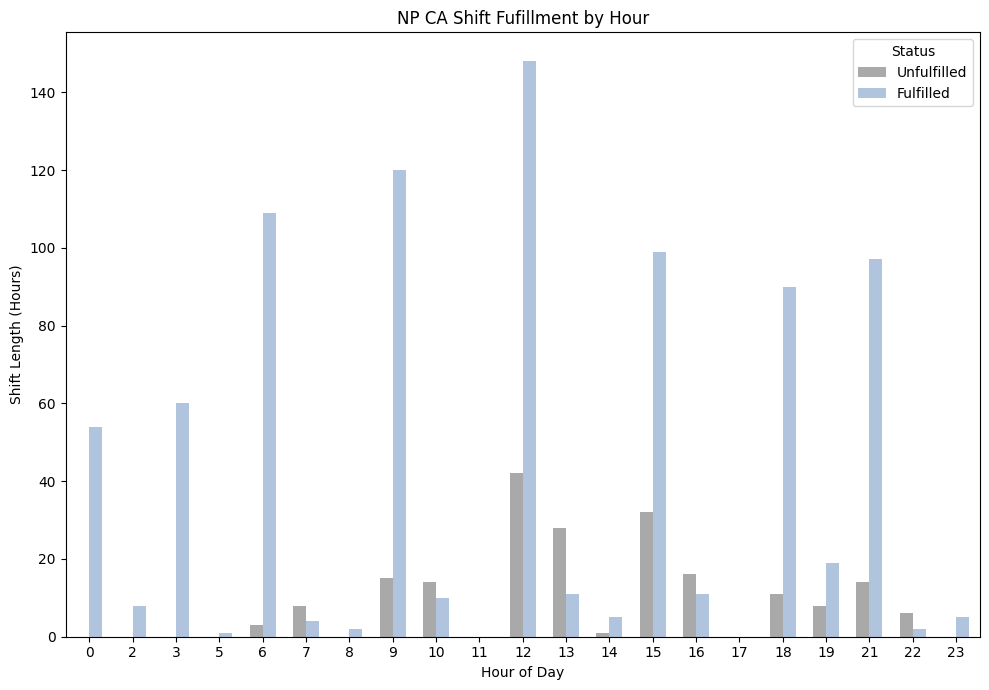

In [11]:
hour.plot(kind='bar', width = .6,figsize=(10, 7), color=['darkgrey','lightsteelblue'])
plt.title('NP CA Shift Fufillment by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Shift Length (Hours)')
plt.xticks(rotation=0)

plt.legend(title='Status')
plt.tight_layout()
# plt.savefig('Issue1_chart3.png', dpi=300) 
plt.show()

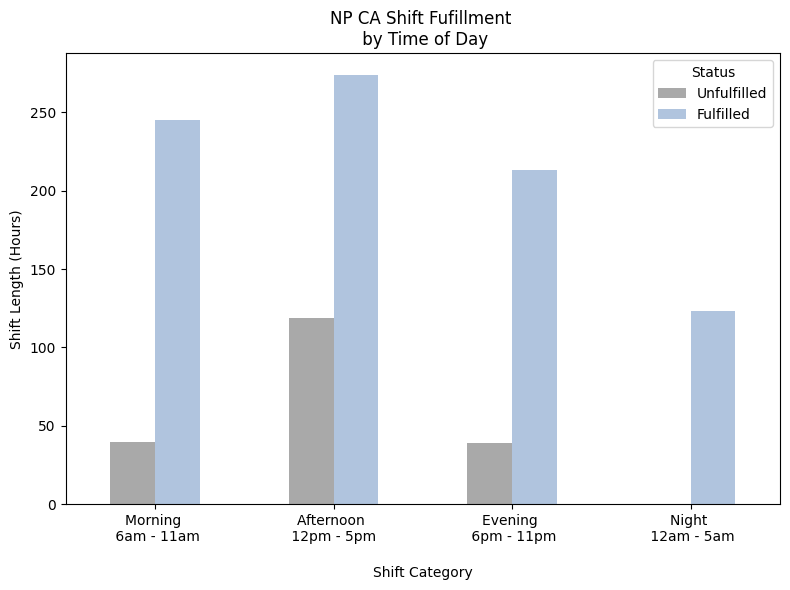

In [12]:
# Plot the stacked bar chart
ax = day.plot(kind='bar', figsize=(8, 6), color=['darkgrey','lightsteelblue'])
plt.title('NP CA Shift Fufillment \n by Time of Day')
plt.xlabel('Shift Category')

labels = ['Morning \n 6am - 11am', 'Afternoon \n 12pm - 5pm \n', 'Evening \n 6pm - 11pm', 'Night \n 12am - 5am']
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
plt.xticks(rotation=0)
plt.ylabel('Shift Length (Hours)')

plt.legend(title='Status')


plt.tight_layout()
# plt.savefig('Issue1_chart4.png', dpi=300) 
plt.show()

In [13]:
day

,Unfulfilled,Fulfilled
Shift Category,,
Morning,40.0,245.0
Afternoon,119.0,274.0
Evening,39.0,213.0
Night,0.0,123.0
